In [1]:
## Nav7 agent test code

In [1]:
import functools
import operator
from typing import Annotated, TypedDict, Sequence, Literal
from pydantic import BaseModel

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, BaseMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool
from langchain.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent

### Tools

In [2]:
tavily_tool = TavilySearchResults(max_results=5)
python_repl_tools = PythonREPLTool()

In [ ]:
import feedparser
import urllib.parse

@tool
def google_news_search(query: str) -> str:
    """
    Google News에서 특정 키워드에 대한 최신 기술 트렌드를 검색합니다.
    예시: '인공지능', '블록체인', '사이버 보안'
    """
    # 쿼리 문자열을 URL 인코딩
    encoded_query = urllib.parse.quote(query)
    # Google News RSS 피드 URL (검색 쿼리를 포함)
    rss_url = f"https://news.google.com/rss/search?q={encoded_query}&hl=ko&gl=KR&ceid=KR:ko"

    # feedparser를 사용하여 RSS 피드 파싱
    feed = feedparser.parse(rss_url)

    if not feed.entries:
        return f"'{query}'에 대한 Google News 검색 결과를 찾을 수 없습니다."

    # 최신 뉴스 5개 추출
    news_items = []
    for entry in feed.entries[:5]:
        news_items.append(f"제목: {entry.title}\n링크: {entry.link}\n")

    return "\n".join(news_items)

### Agent

supervisor 아래에 Finish, Summary, LearningPath, RoleModel

In [4]:
members = ["CareerSummary", "LearningPath",  "EXCEPTION"] # "RoleModel",

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    "following workers: {members}. Given the following user request about Job, "
    "respond with the worker to act next. Each worker will perform a "
    "task and respond with their results and status. "
    "if given out of topic, respond with EXCEPTION."
    "When finished, respond with FINISH."
)

options = ["FINISH"] + members

In [5]:
from typing import TypedDict, Optional, List, Dict

# 1. 상태 정의
class GraphState(TypedDict):
    input: str
    responses: Dict[str, str]
    history: List[str]
    current_agent: Optional[str]
    next_agent: Optional[str]

class routeResponse(BaseModel):
    next: Literal[*options]

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH?"
            " Select one of {options}",
        ),
    ]
).partial(
    options=str(options),
    members=", ".join(members)
)

llm = ChatOpenAI(model="gpt-4o-mini")

# main chatbot supervisor
def supervisor_agent(state):
    supervisor_chain = (
        prompt | llm.with_structured_output(routeResponse)
    )
    return supervisor_chain.invoke(state)

### 하위 에이전트 구성

In [6]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}

In [7]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str # 다음 노드 지시 (supervisor 결과)

In [8]:
# CareerSummary
cs_system_prompt = """
You are a helpful summarizer who is specialized in 
gethering valuable info for given user career information and query.
user's career information={information}
----
You have to made KOREAN career summary script.

example:

**ooo님은 5년차 백엔드 개발 전문가입니다.**

- 🔹 총 프로젝트: 12건
- 🔹 보유 자격증: AWS Solutions Architect, OCP, 정보처리기사 (총 3개)
- 🔹 핵심 기술 스택: Python, Spring Boot, Docker, MySQL, AWS

**주요 성과**

1. A사 주문관리 시스템 리팩토링 → 응답 속도 30% 향상
2. B사 인프라 자동화 도입 프로젝트 주도
3. OCP 취득 후 쿠버네티스 기반 배포 파이프라인 구현

"""
  # agent 생성
careerSummary_agent = create_react_agent(
    llm, 
    tools = [],
    state_modifier=cs_system_prompt
)
careerSummary_node = functools.partial(
    agent_node,
    agent = careerSummary_agent,
    name="CareerSummary"
)

# LearningPath
lp_prompt="""
You are a highly experienced consultant across multiple industries.

Based on the user's career history and past experiences, your task is to:
- Recommend clear professional goals for the user.
- Suggest actionable steps to achieve those goals, including relevant skills to learn, projects to undertake, and certifications to pursue.

Do not repeat information the user already has experience in.  
Focus instead on new, meaningful paths for professional growth tailored to the user’s current situation.

You may use predefined tools to retrieve any additional information needed.  
Organize your final recommendations into categories (e.g., Skills, Projects, Certifications, etc.).

⚠️ All responses must be written in Korean.
"""
learningPath_agent = create_react_agent(
    llm, 
    tools=[tavily_tool, google_news_search],
    state_modifier=lp_prompt
)
learningPath_node = functools.partial(
    agent_node,
    agent=learningPath_agent,
    name="LearningPath"
)


# Exception
ex_system_prompt = """
If the user's query is not related to career development or career analysis,  
kindly inform the user that you are only able to assist with career-related topics, and end the conversation.
"""
  # agent 생성
exception_agent = create_react_agent(
    llm, 
    tools=[],
    state_modifier=ex_system_prompt
)
exception_node = functools.partial(
    agent_node,
    agent = exception_agent,
    name="Exception"
)

In [9]:
workflow = StateGraph(AgentState)

workflow.add_node("CareerSummary", careerSummary_node)
workflow.add_node("LearningPath", learningPath_node)
workflow.add_node("EXCEPTION", exception_node)
workflow.add_node("supervisor", supervisor_agent)

for member in members:
    workflow.add_edge(member, "supervisor")

conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END

# supervisor state의 next 값에 따라 조건부 진행
"""
## params of add_conditional_edges ##
-source(str): starting node
-path(Union[Callable Runnable]): determines the next node or nodes
-path_map(Optional[dict[Hashable, str]]): mapping of paths to node names
-then(Optional[str], default: None) 

--> Return
Self: (instance of the graph)
"""
workflow.add_conditional_edges(
    "supervisor", 
    lambda x: x["next"], # name of next node
    conditional_map)     # path of next node

workflow.add_edge(START, "supervisor")

graph = workflow.compile()

In [10]:
conditional_map

{'CareerSummary': 'CareerSummary',
 'LearningPath': 'LearningPath',
 'EXCEPTION': 'EXCEPTION',
 'FINISH': '__end__'}

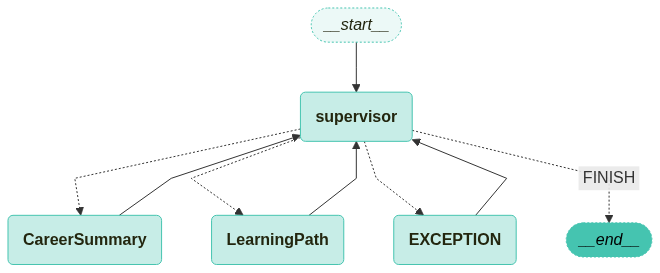

In [11]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

### 실행

In [14]:
for s in graph.stream({"messages": [HumanMessage(content="AI쪽 PM이 되고 싶으면 어떻게 해야 하나요?")]}):
    if "__end__" not in s: # state
        print(s)
        print("----")

{'supervisor': {'next': 'LearningPath'}}
----
{'LearningPath': {'messages': [HumanMessage(content='AI 프로젝트 매니저(PM)로의 경로를 원하신다면, 다음과 같은 구체적인 목표와 단계별 계획을 추천드립니다.\n\n### 1. 전문 목표 설정\n- **AI 프로젝트 관리 전문성 강화**: AI 관련 프로젝트를 성공적으로 관리할 수 있는 능력 배양.\n- **AI 기술 이해도 향상**: AI 기술 전반에 대한 깊은 이해를 바탕으로 프로젝트를 이끌어 갈 능력 개발.\n\n### 2. 필요한 기술\n- **데이터 분석 및 머신러닝 기초**: Python, R과 같은 프로그래밍 언어를 배우고, 데이터 분석, 머신러닝 알고리즘에 대한 이해를 높이세요.\n- **프로젝트 관리 도구**: Jira, Trello, Asana와 같은 도구를 활용하여 프로젝트 관리 능력을 배양하세요.\n- **AI 관련 기술**: TensorFlow, PyTorch 등의 AI 프레임워크에 대한 기본적인 이해가 필요합니다.\n\n### 3. 프로젝트 제안\n- **AI 기반의 프로젝트 수행**: 실제로 AI 모델을 개발하거나, AI 기술을 활용한 프로젝트를 계획하고 실행해 보세요. 예를 들어, 고객 데이터를 분석하여 예측 모델을 만드는 프로젝트나, AI를 활용한 비즈니스 프로세스 개선 프로젝트를 진행할 수 있습니다.\n- **AI와 관련된 해커톤 참여 또는 관련 대회 참가**: 다양한 팀과 협업하여 실질적인 경험을 쌓는 좋은 기회입니다.\n\n### 4. 인증 및 교육\n- **AI 및 데이터 과학 관련 인증**: Coursera, edX, Udacity 등에서 제공하는 AI 및 데이터 과학 관련 인증 과정을 이수하세요. 예를 들어, Google의 AI 인증, IBM의 데이터 과학 인증 등이 있습니다.\n- **PM 관련 자격증**: PMP(프로젝트 관리 전문가) 또는 PRINCE2 인증을 통해 프로젝트 관리 능력을 공